<p align="center">
  <img width="300" height="300" src="https://www.linkpicture.com/q/VISTRKR_Logo1.png">
</p>

## Modules

In [1]:
import numpy as np
import pandas as pd
import math
import sys

main_path = r"C:\Users\97254\OneDrive - Technion\Technion\09 Semester G\084653\Semester B\Week 01\pythonProject"
sys.path.insert(1, main_path)

# Import functions from different modules
from calibration import calib_functions
from estimation import estim_functions
from simulation import sim_functions

from main import calibrate_cameras, estimate_position, simulate_data, simulate_calibration

from data.general import *

## Calibration

In [2]:
cameras_data = simulate_calibration(cameras_data, calibration_points, angle_error_std=10, pixel_error_std=30)

with open("calibrated_cameras_data.txt", 'w') as file:
    for camera in cameras_data:
        for key, value in camera.items():
            if key in ['name', 'position', 'azimuth', 'true_azimuth']:
                if isinstance(value, float):
                    file.write(f'{value:.2f}\t\t')
                else:
                    file.write(f'{value}\t\t')
        file.write(f'\n')
        
calibration_points

[(3, 2.5), (10, 10), (5, 16), (18, 2), (4, 4), (18, 10)]

## Raw Visualization

<IPython.core.display.Javascript object>


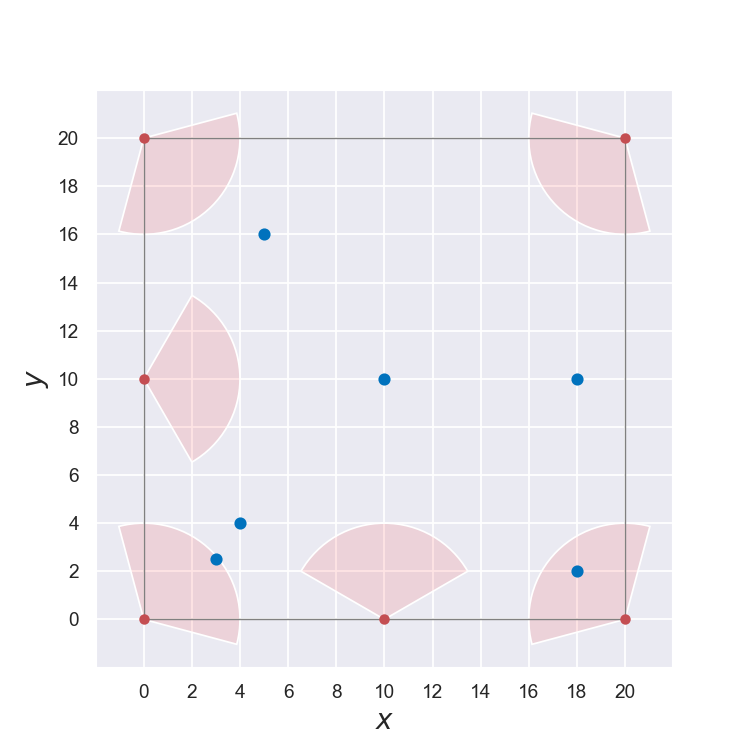

In [8]:
calibration_points = np.array(calibration_points)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from visualization.vis_functions import plot_filled_sector

%matplotlib notebook
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')

ax.plot(calibration_points[:, 0], calibration_points[:, 1], 'o', c='#0072BD')

for camera in cameras_data:
    plot_filled_sector(camera['position'], camera['azimuth'], 4, camera['angle_of_view'], ax, sector_color=[1, 0, 0, .1])
    
ax.hlines([0, 20], 0, 20, colors='grey', lw=.8)
ax.vlines([0, 20], 0, 20, colors='grey', lw=.8)


ax.set_xticks(np.arange(0, 21, 2)) ; ax.set_yticks(np.arange(0, 21, 2))
ax.set_xlim([-2, 22]) ; ax.set_ylim([-2, 22])
ax.set_xlabel('$x$', size=16) ; ax.set_ylabel('$y$', size=16)

plt.show()

In [4]:
pd.DataFrame(cameras_data)[['name', 'position', 'azimuth', 'true_azimuth', 'calculated_azimuth']]

,name,position,azimuth,true_azimuth,calculated_azimuth
0,X1,"(10, 0)",90,86.523742,86.419055
1,Y1,"(0, 10)",0,-4.557298,-5.079656
2,O,"(0, 0)",45,51.245767,50.610878
3,X2,"(20, 0)",135,147.969669,149.115106
4,Y2,"(0, 20)",-45,-43.311595,-44.496351
5,F,"(20, 20)",225,229.304429,238.949134


## Parameters

In [5]:
NUMBER_OF_POINTS = 150
ERROR = 30 # pixel white gaussian noise STD

## Data Analysis

In [6]:
# Define a lambda function foo(x)
# foo = lambda x: 1.5 * np.cos(x / .8) - x + 16
foo = lambda x: 0.6*(x - 5.8)**3 + 1.5*(x - 5.8)**2 + -1.1*x + 13

# Generate points using the sim_functions module
simulated_points = sim_functions.generate_2d_points(foo, x_range=[1, 19], y_range=[1, 19], density=NUMBER_OF_POINTS)

# Simulate measurements using the cameras_data and generated points
measurements = simulate_data(cameras_data, simulated_points, noise_std=ERROR)

# Estimate the position of the points using cameras_data and measurements
estimated_points = estimate_position(cameras_data, measurements)

## Visualization

<IPython.core.display.Javascript object>


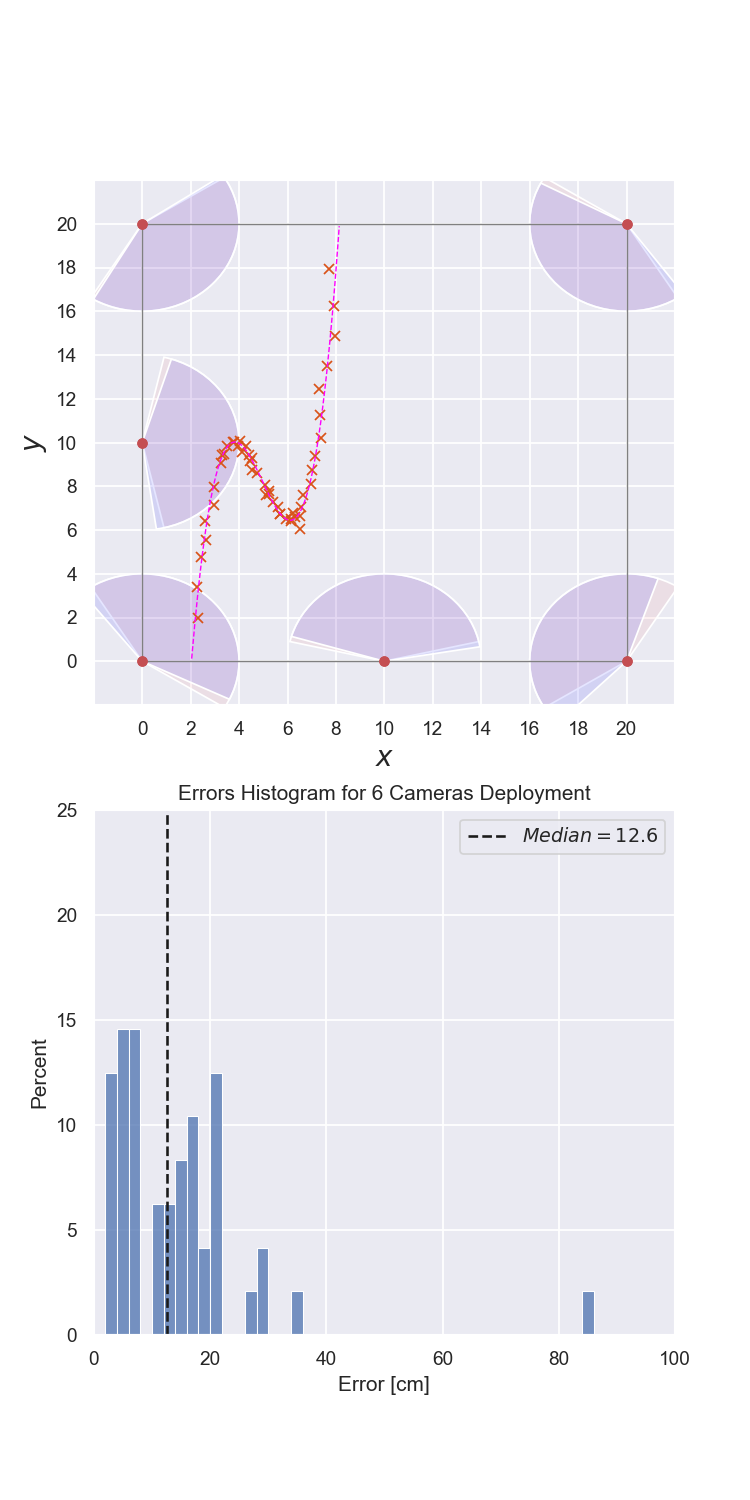

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from visualization.vis_functions import plot_filled_sector

%matplotlib notebook
sns.set(style='darkgrid')

X = np.linspace(0, 20, 500)
Y = foo(X)
mask = (0<=X) & (X<=20) & (0<=Y) & (Y<=20)
simulated_points = np.array(simulated_points)

fig, ax = plt.subplots(2, 1, figsize=(6,12))
# ax[0].set_aspect('equal')

# ax[0].plot(simulated_points[:, 0], simulated_points[:, 1], 'o', c='#0072BD')
ax[0].plot(estimated_points[:, 0], estimated_points[:, 1], 'x', c='#D95319')
ax[0].plot(X[mask], Y[mask], lw=.8, ls='--', c='#FF00FF')

for camera in cameras_data:
    plot_filled_sector(camera['position'], camera['azimuth'], 4, 155, ax[0], sector_color=[1, 0, 0, .05])
for camera in cameras_data:
    plot_filled_sector(camera['position'], camera['true_azimuth'], 4, 155, ax[0], sector_color=[0, 0, 1, .1])
    
ax[0].hlines([0, 20], 0, 20, colors='grey', lw=.8)
ax[0].vlines([0, 20], 0, 20, colors='grey', lw=.8)


ax[0].set_xticks(np.arange(0, 21, 2)) ; ax[0].set_yticks(np.arange(0, 21, 2))
ax[0].set_xlim([-2, 22]) ; ax[0].set_ylim([-2, 22])
ax[0].set_xlabel('$x$', size=16) ; ax[0].set_ylabel('$y$', size=16)


errors = np.linalg.norm(simulated_points - estimated_points, axis=1)
err_median = np.median(errors*100)

sns.histplot(errors*100, stat="percent", binwidth=2, binrange=(0, 100), ax=ax[1])
ax[1].set(
    xlabel='Error [cm]',
    ylim=(0, 25),
    xlim=(0, 100),
    title='Errors Histogram for {:d} Cameras Deployment'.format(len(cameras_data)))
ax[1].axvline(err_median, color='k', ls='--')
ax[1].legend([f"$Median={err_median:.1f}$"])

plt.show()
# fig.savefig(f'errors_{len(cameras_data):d}_cameras.png', dpi=600)